# Chapter 06

✅ 완전 연결 계층을 이용한 AE

In [6]:
# 완전 연결 계층 AE 모델링

from keras import layers,models 

class AE(models.Model):
    def __init__(self, x_nodes = 784, z_dim = 36):
        x_shape = (x_nodes,)
        x = layers.Input(shape = x_shape)
        z = layers.Dense(z_dim, activation='relu')(x)
        y = layers.Dense(x_nodes, activation = 'sigmoid')(z)
        
        super().__init__(x,y)
        
        self.x = x
        self.z = z
        self.z_dim = z_dim
        
        self.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
    def Encoder(self):
        return models.Model(self.x, self.z)
        
    def Decoder(self):
        z_shape = (self.z_dim,)
        z = layers.Input(shape = z_shape)
        y_layer = self.layers[-1]   # self.layers[-1]은 제일 마지막 부분. 즉 AE 자신의 출력 계층이라는 의미
        y = y_layer(z)
        return models.Model(z,y)

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.3553 - accuracy: 0.7559 - val_loss: 0.2720 - val_accuracy: 0.7944
Epoch 2/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2664 - accuracy: 0.7967 - val_loss: 0.2574 - val_accuracy: 0.7971
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.2469 - accuracy: 0.7984 - val_loss: 0.2332 - val_accuracy: 0.7975
Epoch 4/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2248 - accuracy: 0.7980 - val_loss: 0.2141 - val_accuracy: 0.7977
Epoch 5/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2086 - accuracy: 0.7989 - val_loss: 0.2003 - val_accuracy: 0.7996
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1964 - accuracy: 0.8002 - val_loss: 0.1900 - val_accuracy: 0.8010
Epoch 7/10
60000/60000 [==================

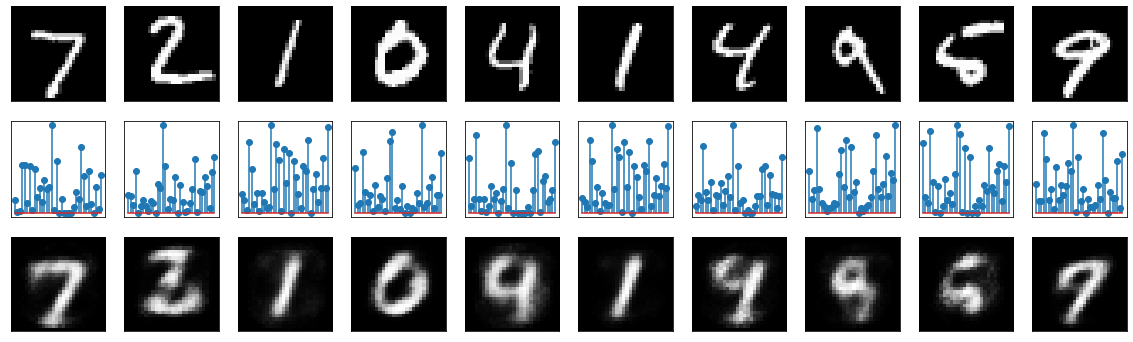

In [8]:
# 데이터 준비

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(X_train, _),(X_test, _) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))  # 첫번 째는 이미지 수, 두 번째는 바꾼 후의 이미지 길이?
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

# 완전 연결 계층 AE 동작 확인

def show_ae(autoencoder):
    encoder = autoencoder.Encoder()
    decoder = autoencoder.Decoder()
    
    encoded_imgs = encoder.predict(X_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    n = 10
    plt.figure(figsize = (20,6))
    
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        plt.imshow(X_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)    # 이미지 주변 축들은 보이지 않도록 함
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i+1+n)
        plt.stem(encoded_imgs[i].reshape(-1))
        plt.gray()
        ax.get_xaxis().set_visible(False)    # 이미지 주변 축들은 보이지 않도록 함
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i+1+n+n)
        plt.imshow(decoded_imgs[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# 학습 및 성능 평가

def main():
    x_nodes = 784
    z_dim = 36
    
    autoencoder = AE(x_nodes,z_dim)
    history = autoencoder.fit(X_train,X_train, epochs = 10, batch_size = 256, shuffle = True, validation_data = (X_test,X_test))
    
    show_ae(autoencoder)
    plt.show()
    
if __name__ == '__main__':
    main()

✅ 합성곱 계층을 이용한 AE

In [13]:
# 합성곱 AE 모델링

from keras import layers,models
import keras

def Conv2D(filters, kernel_size, padding = 'same', activation='relu'):
    return layers.Conv2D(filters,kernel_size, padding = padding, activation = activation)

class AE(models.Model):
    def __init__(self,org_shape = (1,28,28)):
        original = layers.Input(shape = org_shape)
        
        # encoding 1
        x = Conv2D(4, (3,3))(original)
        x = layers.MaxPooling2D((2,2), padding = 'same')(x)
        
        # encoding 2
        x = Conv2D(8, (3,3))(x)
        x = layers.MaxPooling2D((2,2), padding = 'same')(x)
        
        # encoding 3 : encoding output - 7 * 7 pixels
        z = Conv2D(1, (7,7))(x)
        
        # decoding 1
        y = Conv2D(16,(3,3))(z)
        y = layers.UpSampling2D((2,2))(y)
        
        # decoding 2
        y = Conv2D(8,(3,3))(y)
        y = layers.UpSampling2D((2,2))(y)
        
        # decoding 3
        y = Conv2D(4,(3,3))(y)
        
        # decoding & output
        decoded = Conv2D(1,(3,3), activation='sigmoid')(y)
        
        super().__init__(original,decoded)
        self.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics=['accuracy'])

# 데이터 준비 
from keras import datasets 

class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

# 합성곱 AE 결과 시각화
from keras import backend

def show_ae(autoencoder,data):
    x_test = data.x_test
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)
    
    if backend.image_data_format() == 'channels_first':
        N,n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape 
        
    x_test = x_test.reshape(N, n_i, n_j)   # 차원 변경
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],n_i,n_j)   # 입력 데이터와 AE 결과 데이터가 채널 포함해 3차원이기 때문에 시각화 위해 3차원으로 변경
    
    n = 10
    plt.figure(figsize(20,4))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(x_test[i])
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded_imgs[i])
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
# 합성곱 AE 학습 및 성능 평가
# def plot_acc(history, title=None):
#     # summarize history for accuracy
#     if not isinstance(history, dict):
#         history = history.history

#     plt.plot(history['acc'])
#     plt.plot(history['val_acc'])
#     if title is not None:
#         plt.title(title)
#     plt.ylabel('Accracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Training data', 'Validation data'], loc=0)
#     # plt.show()


# def plot_loss(history, title=None):
#     # summarize history for loss
#     if not isinstance(history, dict):
#         history = history.history

#     plt.plot(history['loss'])
#     plt.plot(history['val_loss'])
#     if title is not None:
#         plt.title(title)
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def main(epochs=20,batch_size = 128):
    data = DATA()
    autoencoder = AE(data.input_shape)
    history = autoencoder.fit(data.x_train,data.x_train,epochs = epochs, batch_size = batch_size, shuffle=True, validation_split = 0.2)

if __name__ == '__main__':
    main()
    
    

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.2164 - accuracy: 0.7987 - val_loss: 0.1424 - val_accuracy: 0.8071
Epoch 2/20
48000/48000 [==============================] - 79s 2ms/step - loss: 0.1340 - accuracy: 0.8048 - val_loss: 0.1241 - val_accuracy: 0.8066
Epoch 3/20
48000/48000 [==============================] - 81s 2ms/step - loss: 0.1237 - accuracy: 0.8080 - val_loss: 0.1183 - val_accuracy: 0.8071
Epoch 4/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.1164 - accuracy: 0.8094 - val_loss: 0.1167 - val_accuracy: 0.8132
Epoch 5/20
48000/48000 [==============================] - 88s 2ms/step - loss: 0.1112 - accuracy: 0.8105 - val_loss: 0.1078 - val_accuracy: 0.8101
Epoch 6/20
48000/48000 [==============================] - 92s 2ms/step - loss: 0.1072 - accuracy: 0.8112 - val_loss: 0.1025 - val_accuracy: 0.8134
Epoch 7/20
48000/48000 [==============================] - 89s 2ms/st